This notebook is a template for a default 16s V4 marker gene analysis. I assume data arrive in terms for raw Illumina files (a complex directory structure of \*.bcl files) and metadata describing the samples as excel file or another type of spreadsheet.

Should the metadata not yet exist, I recommend 1) use https://qiita.ucsd.edu/iframe/?iframe=qiimp to produce an according excel template and 2) do **not** start any analysis until you know your samples. Any efforts without these data is a waste of time!

In [ ]:
# toggle between "notebook" and "inline", if graphs are not directly displayes
%matplotlib  inline

In [ ]:
%load_ext autoreload
%autoreload 2

from ggmap.workflow import *

# use the following two information to create according github repo and project directory on lummerland
PROJECT_PI = 'YOURNAME'
PROJECT_NAME = 'YOURPROJECTNAME'

In [ ]:
# this object will hold many of the preprocessing data
# be careful to re-set it as you will have to re-do multiple steps to recreate these infos
prj_data = dict()

## Load metadata

In [ ]:
prj_data['metadata'] = pd.read_csv('PATH TO YOUR FILE', sep="\t", dtype=str, na_values=['not applicable'], index_col=0)
prj_data['metadata']

# Process data
## Initiate new project

In [ ]:
prj_data = init_project(pi=PROJECT_PI, name=PROJECT_NAME, prj_data=prj_data, force=False)
# Should you receive file permission errors, it could well be the case that Stefan already 
# executed this function (for you) and directory structure already exists. Try to set
# force=True and re-execute!

## Deposit raw data
After calling the `init_project()` function above, you should start moving raw data into newly created directory structure, i.e.
  - raw Illumina data
  - Illumina demultiplexing sheet

## BaseCalling + Demulitplex

In [ ]:
prj_data = project_demux(
    'PATH TO YOUR ILLUMINA RAW DATA', 
    'PATH TO YOUR DEMUX-SHEET IN CSV FORMAT', 
    prj_data)

## Trim primers

In [ ]:
prj_data = project_trimprimers(
    "GTGCCAGCMGCCGCGGTAA", 
    "GGACTACHVGGGTWTCTAAT", prj_data)
# we expect per sample fastq files to follow the default naming schema: _R1_001.fastq.gz
# should this not apply to your data, supply the optional parameters: pattern_fwdfiles and/or r1r2_replace

## Deblur

In [ ]:
prj_data = project_deblur(prj_data)
# we expect per sample fastq files to follow the default naming schema: _R1_001.fastq.gz
# should this not apply to your data, supply the optional parameters: pattern_fwdfiles (we never use reverse reads for Deblur, thus r1r2_replace is not available)

## SEPP

In [ ]:
prj_data = project_sepp(prj_data)

before starting big compute, double check sources of metadata and feature table. It is not unlikely that you partially use data from Qiita and mix with local metadata that lack qiita-study-id prefix like `14078.`

In [ ]:
qiita_metadata = any(map(lambda x: 'qiita' in x.lower(), prj_data['metadata'].columns)) and all(map(lambda x: re.match('^\d+\.', x) is not None, prj_data['metadata'].index))
qiita_counts = all(map(lambda x: re.match('^\d+\.', x) is not None, biom2pandas(prj_data['paths']['deblur_table']).columns))
if (qiita_metadata != qiita_counts) and (len(set(qiita_metadata.index) & set(biom2pandas(prj_data['paths']['deblur_table']).columns))) <= 0:
    raise ValueError("Please double check that both, metadata and feature table stem from Qiita or other sources. It looks like sample indices do not match!")

## Rarefaction + Diversity + Emperor

You have to run the below function at least twice: 
 - First, to get rarefaction curves, which you will use to determine a rarefaction depth for samples to compute diversity values
 - Second, alpha- beta- and emperor computation need ONE specific `rarefaction_depth` value, which you have determined in step 1

In [ ]:
idx_control_samples = set(prj_data['metadata'][prj_data['metadata']['sample_type'] == 'control'].index)
res_all = process_study(
    metadata=prj_data['metadata'],
    control_samples=idx_control_samples,
    fp_deblur_biom=prj_data['paths']['deblur_table'],
    fp_insertiontree=prj_data['paths']['insertion_tree'],
    rarefaction_depth=7000,
    fp_taxonomy_trained_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg-13-8-99-515-806-nb-classifier_2021.4.qza',
    tree_insert=prj_data['insertion_tree'],
    is_v4_region=True,
    emperor_fp=prj_data['paths']['Generated/Emperor'],
    emperor_infix='_deblur_',
    dry=False,
    use_grid=True,
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
)

### stratify rarefaction curves by metadata

In [ ]:
_ = rarefaction_curves(
    res_all['counts_plantsremoved'], 
    reference_tree=prj_data['paths']['insertion_tree'], 
    control_sample_names=idx_control_samples, 
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    sample_grouping=prj_data['metadata']["diseased"], 
    dry=False)

# Explore Data

## Taxonomy Barplot

In [ ]:
p = plotTaxonomy(res_all['rarefaction']['results'], prj_data['metadata'], file_taxonomy=res_all['taxonomy']['RDP']['results']['Taxon'],
                 group_l1='sample_type', rank='Family',
                 print_sample_labels=True)
p[0].set_size_inches((15, 5))

## Correlation: within metadata
Without knowing too much about the metadata, let is check if the different columns correlate with each other. If so, we have redundant information and it might be worth ignoring one of the columns in downstream analysis.

We need to classify metadata columns into four categories to optimally harvest statistical power:
  - dates, e.g. `collection_timestamp`: `2021-12-06 00:00:00`
  - interval data, e.g. `host_height` in cm: `186`
  - ordinal data, e.g. `shower_frequency`: `once per week` < `every day` < `multiple times per day`
  - categorial data, e.g. `genotype`: `balb`, `black6`

In [ ]:
cols_ignore = set()
for c in prj_data['metadata'].columns:
    if prj_data['metadata'][c].dropna().unique().shape[0] == 1:
        # ignore column, since it contains only ONE value for all samples
        cols_ignore.add(c)
    if prj_data['metadata'][c].dropna().unique().shape[0] == prj_data['metadata'][c].dropna().shape[0]:
        # ignore column, since every sample comes with another value
        cols_ignore.add(c)

cols_date = { # a dictionary where key = column name and value = format string to correctly parse date information
    # 'collection_timestamp': '%Y-%m-%d %h:%m:%s'
}
cols_interval = set([
    # host_height,
])
cols_ordinal = { # note this is a dictionary with keys = column names and values = lists of potential strings in the metadata ORDERED in the list
    # 'shower_frequency': ['once per week', 'every day', 'multiple times per day'],
}
cols_categorial = set([
    # 'genotype',
    'diseased', 'sample_type'
])

In [ ]:
# use this output to decide how to classify remaining metadata columns
# when done, this function should not output anything
for c in prj_data['metadata'].columns:
    if c in cols_ordinal.keys() or c in cols_ignore or c in cols_categorial or c in cols_date.keys() or c in cols_interval:
        continue
    print(c, prj_data['metadata'][c].value_counts(dropna=False))
    print("--------")

In [ ]:
res_corrmeta = correlate_metadata(prj_data['metadata'][list(set(prj_data['metadata'].columns) - set(cols_ignore))], categorials=list(cols_categorial), ordinals=cols_ordinal, dates=cols_date, intervals=list(cols_interval))
display(res_corrmeta[1])

## Correlation: metadata with microbiome
We are throwing a whole arsenal of statistical tests on multiple metrics to the data to find something that looks significant. Go through the resulting table of p-values and look for significant ones that you can further investigate

In [ ]:
corr_diversity = correlation_diversity_metacolumns(
    prj_data['metadata'][sorted(list(set(cols_categorial) | set(cols_date.keys()) | set(cols_ordinal.keys()) | set(cols_interval)))].fillna('NaN'),
    list(sorted(set(cols_categorial) | set(cols_ordinal.keys()))),
    res_all['alpha_diversity']['results'], 
    res_all['beta_diversity']['results'],
    dry=False, wait=False, use_grid=True, dirty=True)

In [ ]:
pd.pivot_table(data=corr_diversity['results'], columns='column', index=['div','type','metric','test'], values='p-value').fillna("")

collapse above table to smallest p-value per column.

In [ ]:
sig_cols = {k for k,v in corr_diversity['results'].groupby('column')['p-value'].min().iteritems() 
            if v < 0.05 
            if k != '__fake_qiime2_numcol'}
display(corr_diversity['results'][corr_diversity['results']['column'].isin(sig_cols)].groupby('column')['p-value'].min())

In [ ]:
# subset columns to those that significantly correlate with microbiome data
# you should manually reduce the number of columns you want to investigate, 
# since every addition of a column costs a lot of statistical power and a too complex model might find nothing at all!
model_cols_date = {k: v for k,v in cols_date.items() if k in sig_cols}
model_cols_interval = {c for c in cols_interval if c in sig_cols}
model_cols_ordinal = {k: v for k,v in cols_ordinal.items() if k in sig_cols}
model_cols_categorial = {c for c in cols_categorial if c in sig_cols}

In [ ]:
sns.set_style("whitegrid")
usegrid = True

max_rows = max(len(res_all['alpha_diversity']['results'].keys()), len(res_all['beta_diversity']['results'].keys()))
fig, axes = plt.subplots(max_rows, 2, figsize=(5*2, 5*max_rows))
for i, metric in enumerate(res_all['alpha_diversity']['results'].keys()):
    redundancy_analysis_alpha(prj_data['metadata'][sorted(list(set(model_cols_categorial) | set(model_cols_date.keys()) | set(model_cols_ordinal.keys()) | set(model_cols_interval)))],
                              res_all['alpha_diversity']['results'][metric],
                              categorials=list(model_cols_categorial), intervals=list(model_cols_interval), dates=model_cols_date, ordinals=model_cols_ordinal,
                              ax=axes[i][0], title='%s' % metric,
                              dry=False, wait=False, use_grid=usegrid)
for i, metric in enumerate(res_all['beta_diversity']['results'].keys()):
    redundancy_analysis_beta(prj_data['metadata'][sorted(list(set(model_cols_categorial) | set(model_cols_date.keys()) | set(model_cols_ordinal.keys()) | set(model_cols_interval)))],
                             res_all['beta_diversity']['results'][metric], metric,
                             categorials=list(model_cols_categorial), intervals=list(model_cols_interval), dates=model_cols_date, ordinals=model_cols_ordinal,
                             ax=axes[i][1], title='%s' % metric,
                             dry=False, wait=False, use_grid=usegrid)

# Specific Analysis types
All above analysis can be applied on any kind of dataset. The following assume specific experimental designs and/or hypothesis you want to follow, i.e. it might **not** make sense for you to execute them! Decide yourself.

## Temporal Analysis
You might have time series data, i.e. multiple samples from the same individual across time. To visualize the experimental design, you might want to compute a "Gantt"-chart of the samples timepoints per individual. Here is an example:
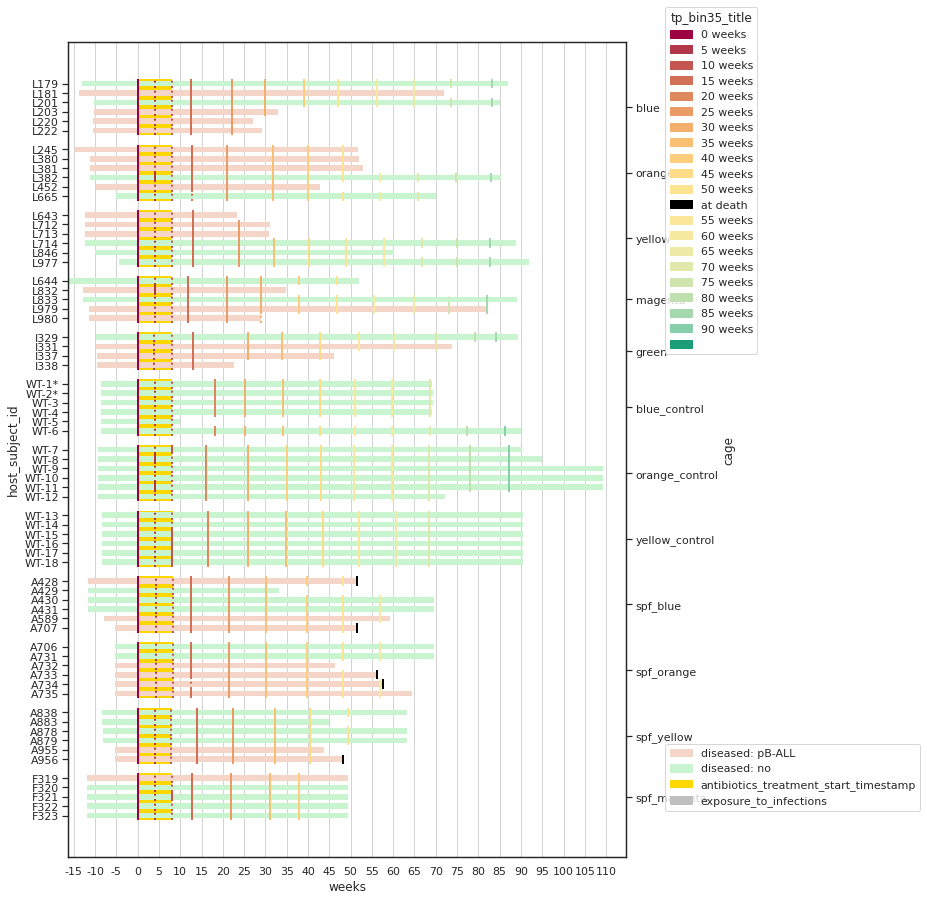
(from https://github.com/jlab/microbiome_pax5/blob/master/4Cohorts/pax5_cohousing_abx_bmt.ipynb)

In [ ]:
chart, col, info = ganttChart(
    prj_data['metadata'],
    col_birth='birth_timestamp',  # metadata column that flags the start of the timeline, must be some parsable dates like 2022-10-09
    col_entities='host_subject_id',  # metadata column that contains name of the person/animal which has been sampled over time, i.e. to know which samples belong to the same line
    col_events='collection_timestamp', # metadata column that indicate the exact date when samples have been collected
    # col_events_title='tp_bin35_title', # you might want to provide a metadata column to give sampling events more speaking names
    # align_to_event_title='0 weeks', # by default, lines are drawn by actual date. However, often it makes sense to align them to the first timepoint of an intervention
    )

## Differential Abundance
One typical line of investigation is the question for differentially abundant taxa between two groups of microbial samples. I suggest two alternative computational approaches for the very same question. 
  1. Ancom is the more conservative method (=if it reports taxa, they are probably really diff. abundant), 
  2. dsFDR is more liberal regarding correction for multiple hypothesis testing and less well accepted in the field, but reports more
  
### ANCOM
Example: 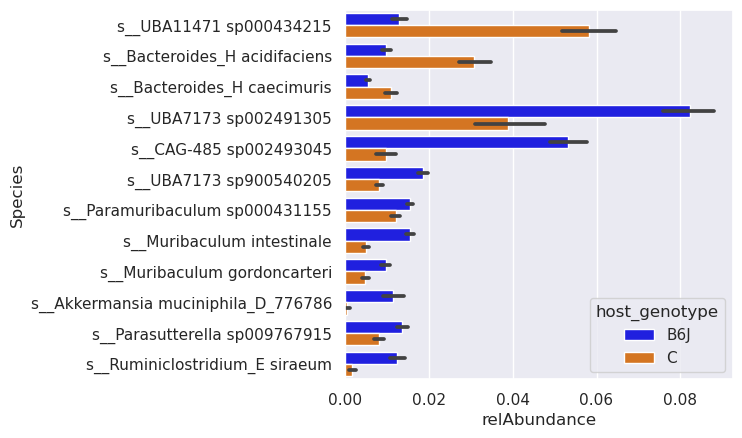

In [ ]:
res_ancom = ancom(
    res_all['rarefaction']['results'],  # you can in principle also start from a feature table NOT being rarefied, i.e. res_all['counts_plantsremoved']
    rank='Genus',  # feature table is collapsed at this taxonomic rank, as ANCOM struggles from too many features like individual ASVs. But try rank="raw" as well!
    taxonomy=res_all['taxonomy']['RDP']['results']['Taxon'],
    grouping=prj_data['metadata']['host_genotype'],  # the metadata column that groups all samples into two conditions
    dry=False, wait=False,
    # following are plotting parameters only, i.e. won't change/trigger a re-run
    min_mean_abundance_per_feature=0.007,
    post_cache_arguments={'palette': {'B6J': 'blue', 'C': 'green'}, 
                          'feature_order': list(name_map.keys()), 
                          'hue_order': ['B6J', 'C']})

### dsFDR
You need to additionally import (and probably install first) the "calor" package: https://github.com/biocore/calour
My code regarding this type of analysis is a bit ugly, since you need to "export" metadata as well as feature counts to actual files before importing them into the calor module :-/

In [ ]:
import calour as ca
ca.set_log_level(40)

In [ ]:
pandas2biom('tmp_dsfrd.biom', res_all['counts_plantsremoved'])
prj_data['metadata'].to_csv('tmp_dsfdr.tsv', sep="\t", index=True)

dsFDR_experiment = ca.read_amplicon('tmp_dsfrd.biom', 
                                    'tmp_dsfdr.tsv', min_reads=0, normalize=10000)

field = 'host_genotype'  # the metadata column that groups all samples into two conditions
res_dsFDR_genotype = find_diff_taxa(dsFDR_experiment, prj_data['metadata'], [field],
                                    # random_seed=43  # hard code a random seed for reproducible results
                                   )

if len(res_dsFDR_genotype) > 0:
    p = plot_diff_taxa(res_all['counts_plantsremoved'],
                       prj_data['metadata'][field], res_dsFDR_genotype,
                       min_mean_abundance=0.0,
                       colors_boxplot={'B6J': 'blue', 'C': 'green'}, 
                       color_barplot='gray'
                      )

## SourceTracking
Assess if a microbial community might be the result of "sourcing" bacteria from different other microbial communities. Imagine you shake hands with four different people. You sample your hand and the four hands of the others and wonder to what degree your microbiome is composed alike the four other hands microbiome.

In [ ]:
sourcetracker2(res_all['counts_plantsremoved'],
               prj_data['metadata'],
               col_envname='st2_env',  # names of the other four people in our example. You might also have samples them multiple times. Thus, multiple samples form the same "source"
               col_type='st2_type',  # define which samples to use as 'Source' and which are the 'Sinks'
               dry=False, wait=False)